#### This one will be used to test simple correlations (XGBoost/Random Forest)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [22]:
# Setup input data
# First one, BMI --> average of all scores

# Calculate BMI
# Calculate BMI from height/weight function
def calculate_bmi(weight_kg, height_cm):
    height_m = height_cm / 100.0
    bmi = weight_kg / (height_m ** 2)
    return bmi
# Extract from height_and_weight.csv
height_weight_df = pd.read_csv('height_and_weight.csv')
height_weight_df['bmi_2022'] = height_weight_df.apply(lambda row: calculate_bmi(row['weight_2022'], row['height_2022']), axis=1)
height_weight_df['bmi_2024'] = height_weight_df.apply(lambda row: calculate_bmi(row['weight_2024'], row['height_2024']), axis=1)
# Return bmi column with id
bmi_df = height_weight_df[['id', 'bmi_2022', 'bmi_2024']].copy()

# remove the bmi_2024 column
bmi_df = bmi_df.drop(columns=['bmi_2024'])
# drop rows with missing bmi_2022
bmi_df = bmi_df.dropna(subset=['bmi_2022'])
bmi_df.head(3)

KeyError: "['age'] not in index"

In [12]:
# Now check for correlation with all glucose scores
# import glucose scores
gluc_scores_df = pd.read_csv('glucose_patterns_by_phase.00.csv')
print(gluc_scores_df.columns)
# convert patient_id to id
gluc_scores_df = gluc_scores_df.rename(columns={'patient_id': 'id'})

# daily cremaster scors
daily_cremaster_scores_df = pd.read_csv('daily_cremaster_scores.00.csv')
print(daily_cremaster_scores_df.columns)
# merge these using id and day_in_study
# 
merged_df = pd.merge(gluc_scores_df, daily_cremaster_scores_df, on=['id', 'day_in_study'], how='inner')
# show
merged_df.head(3)

Index(['patient_id', 'day_in_study', 'phase', 'mean_glucose', 'cv',
       'glucose_range', 'pattern_type', 'pct_low', 'pct_normal',
       'pct_elevated', 'pct_high', 'pct_outside_normal', 'total_points'],
      dtype='object')
Index(['id', 'day_in_study', 'phase', 'daily_mean_glucose',
       'daily_min_glucose', 'daily_max_glucose', 'n_points', 'overnight_mean',
       'cv_glucose', 'mage', 'pp_auc_0_60', 'k_decay',
       'cremaster_score_daily_global'],
      dtype='object')


,id,day_in_study,phase_x,mean_glucose,cv,glucose_range,pattern_type,pct_low,pct_normal,pct_elevated,...,daily_mean_glucose,daily_min_glucose,daily_max_glucose,n_points,overnight_mean,cv_glucose,mage,pp_auc_0_60,k_decay,cremaster_score_daily_global
0,1,1,Follicular,5.498958,11.913258,3.7,Stable,1.041667,56.944444,42.013889,...,5.498958,3.7,7.4,288,5.337500,0.119133,1.508333,65.787083,0.009729,-1.763332
1,1,2,Follicular,5.372222,12.298216,3.3,Stable,0.000000,65.972222,34.027778,...,5.372222,3.9,7.2,288,5.729167,0.122982,0.975000,45.270000,0.002250,-2.005675
2,1,3,Follicular,5.579514,15.080402,5.0,Variable,0.347222,40.972222,57.291667,...,5.579514,3.7,8.7,288,6.133333,0.150804,1.283333,86.335833,0.009199,0.335247


In [14]:
# average scores these across days for each id but first remove non-numerical values (phase_x, pattern_type)
merged_df_clean = merged_df.select_dtypes(include=[np.number])
avg_scores_df = merged_df_clean.groupby('id').mean().reset_index()
# show
avg_scores_df.head(3)





,id,day_in_study,mean_glucose,cv,glucose_range,pct_low,pct_normal,pct_elevated,pct_high,pct_outside_normal,...,daily_mean_glucose,daily_min_glucose,daily_max_glucose,n_points,overnight_mean,cv_glucose,mage,pp_auc_0_60,k_decay,cremaster_score_daily_global
0,1,43.820000,5.145526,13.533568,3.502000,4.808221,69.602259,25.149375,0.440145,30.397741,...,5.145526,3.686000,7.188000,259.200000,5.056637,0.135336,1.299955,52.133885,0.010081,-2.958924
1,2,45.825581,6.249608,15.685387,4.967442,0.819182,25.614669,64.171606,9.394544,74.385331,...,6.249608,4.411628,9.379070,267.941860,5.976546,0.156854,1.944513,72.172407,0.009429,0.843144
2,3,48.515625,6.229421,16.195550,5.425000,0.962234,26.875896,62.521311,9.640560,73.124104,...,6.229421,4.248437,9.673438,267.484375,6.164931,0.161956,2.127801,79.929451,0.011925,1.026987


In [15]:
correlation_results = {}
for column in avg_scores_df.columns:
    if column not in ['id', 'day_in_study']:
        merged_bmi_df = pd.merge(avg_scores_df[['id', column]], bmi_df, on='id', how='inner')
        correlation = merged_bmi_df[column].corr(merged_bmi_df['bmi_2022'])
        correlation_results[column] = correlation
# Show correlation results
for score, corr_value in correlation_results.items():
    print(f"Correlation between BMI 2022 and {score}: {corr_value}")

Correlation between BMI 2022 and mean_glucose: 0.06561450350409176
Correlation between BMI 2022 and cv: -0.4860070841399745
Correlation between BMI 2022 and glucose_range: -0.5499866513474859
Correlation between BMI 2022 and pct_low: -0.4229460619068239
Correlation between BMI 2022 and pct_normal: -0.16541438398144168
Correlation between BMI 2022 and pct_elevated: 0.34356070637135905
Correlation between BMI 2022 and pct_high: -0.27965378070258523
Correlation between BMI 2022 and pct_outside_normal: 0.1654143839814417
Correlation between BMI 2022 and total_points: -0.030909350027448577
Correlation between BMI 2022 and daily_mean_glucose: 0.06561450350409169
Correlation between BMI 2022 and daily_min_glucose: 0.25737576633959824
Correlation between BMI 2022 and daily_max_glucose: -0.38365507454049885
Correlation between BMI 2022 and n_points: -0.030909350027448577
Correlation between BMI 2022 and overnight_mean: 0.3407062988788385
Correlation between BMI 2022 and cv_glucose: -0.486007084

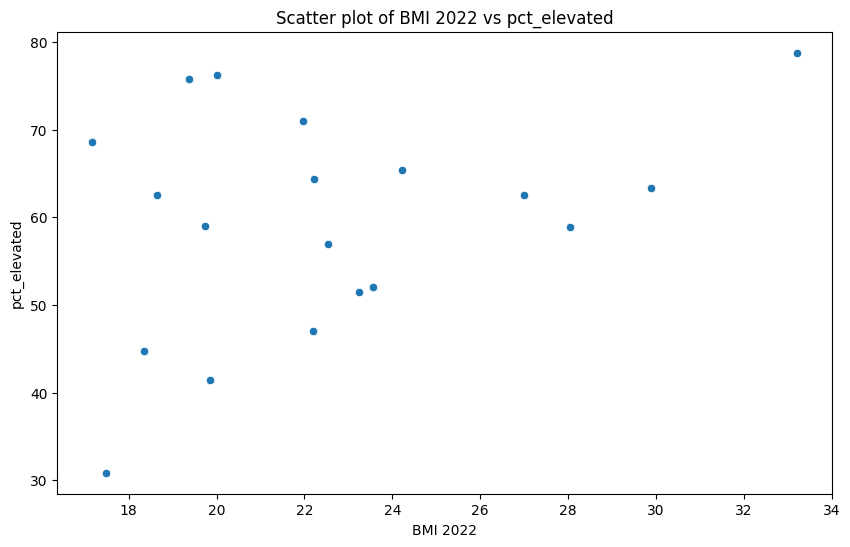

In [21]:
# plot bmi_2022 vs a selected score, e.g., glucose_mean
selected_score = 'pct_elevated'
plt.figure(figsize=(10, 6))
merged_bmi_df = pd.merge(avg_scores_df[['id', selected_score]], bmi_df, on='id', how='inner')
sns.scatterplot(data=merged_bmi_df, x='bmi_2022', y=selected_score)
plt.title(f'Scatter plot of BMI 2022 vs {selected_score}')
plt.xlabel('BMI 2022')
plt.ylabel(selected_score)
plt.show()

In [27]:
# Now group by different periods and phases to see if correlations differ instead of just averaging across all days
merged_df_week = merged_df_clean.copy()
merged_df_week['week_in_study'] = (merged_df_week['day_in_study'] // 7) + 1
grouped_week_df = merged_df_week.groupby(['id', 'week_in_study']).mean().reset_index()
# Now do the same correlation analysis as before but for weekly averages by person
correlation_results_week = {}
for column in grouped_week_df.columns:
    if column not in ['id', 'day_in_study', 'week_in_study']:
        merged_bmi_week_df = pd.merge(grouped_week_df[['id', column]], bmi_df, on='id', how='inner')
        correlation = merged_bmi_week_df[column].corr(merged_bmi_week_df['bmi_2022'])
        correlation_results_week[column] = correlation
# Show correlation results for weekly averages
for score, corr_value in correlation_results_week.items():
    print(f"Weekly Correlation between BMI 2022 and {score}: {corr_value}")
    

Weekly Correlation between BMI 2022 and mean_glucose: 0.06682793782784535
Weekly Correlation between BMI 2022 and cv: -0.4372320518853141
Weekly Correlation between BMI 2022 and glucose_range: -0.47782826474768647
Weekly Correlation between BMI 2022 and pct_low: -0.21107825991543633
Weekly Correlation between BMI 2022 and pct_normal: -0.14521428950310775
Weekly Correlation between BMI 2022 and pct_elevated: 0.2592467760956961
Weekly Correlation between BMI 2022 and pct_high: -0.17332655352881143
Weekly Correlation between BMI 2022 and pct_outside_normal: 0.14521428950310766
Weekly Correlation between BMI 2022 and total_points: 0.0191206119382413
Weekly Correlation between BMI 2022 and daily_mean_glucose: 0.06682793782784531
Weekly Correlation between BMI 2022 and daily_min_glucose: 0.17139083823003118
Weekly Correlation between BMI 2022 and daily_max_glucose: -0.3031938967767501
Weekly Correlation between BMI 2022 and n_points: 0.0191206119382413
Weekly Correlation between BMI 2022 and

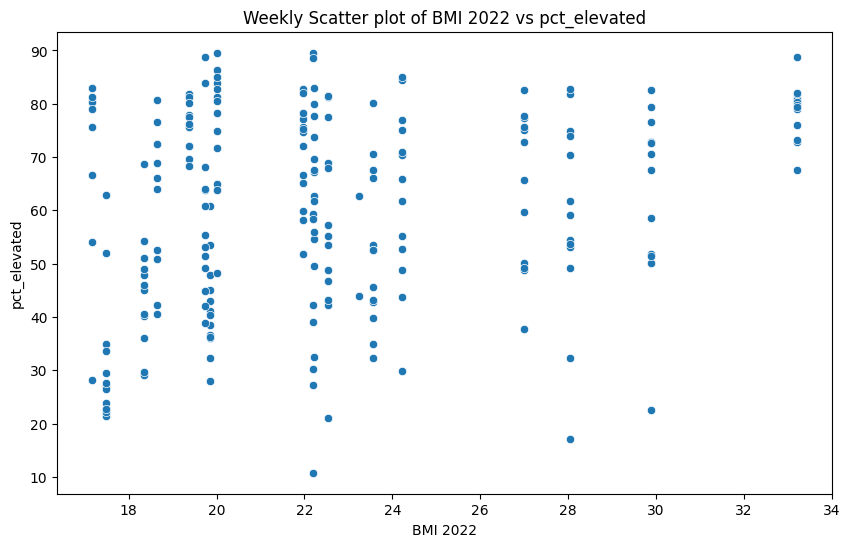

In [28]:
# plot bmi_2022 vs a selected score, e.g., glucose_mean for weekly averages
selected_score = 'pct_elevated'
plt.figure(figsize=(10, 6))
merged_bmi_week_df = pd.merge(grouped_week_df[['id', selected_score]], bmi_df, on='id', how='inner')
sns.scatterplot(data=merged_bmi_week_df, x='bmi_2022', y=selected_score)
plt.title(f'Weekly Scatter plot of BMI 2022 vs {selected_score}')
plt.xlabel('BMI 2022')
plt.ylabel(selected_score)
plt.show()

In [29]:
# Now group by different periods and phases to see if correlations differ instead of just averaging across all days
merged_df_month = merged_df_clean.copy()
merged_df_month['month_in_study'] = (merged_df_month['day_in_study'] // 30) + 1
grouped_month_df = merged_df_month.groupby(['id', 'month_in_study']).mean().reset_index()
# Now do the same correlation analysis as before but for monthly averages by person
correlation_results_month = {}
for column in grouped_month_df.columns:
    if column not in ['id', 'day_in_study', 'month_in_study']:
        merged_bmi_month_df = pd.merge(grouped_month_df[['id', column]], bmi_df, on='id', how='inner')
        correlation = merged_bmi_month_df[column].corr(merged_bmi_month_df['bmi_2022'])
        correlation_results_month[column] = correlation
# Show correlation results for monthly averages
for score, corr_value in correlation_results_month.items():
    print(f"Monthly Correlation between BMI 2022 and {score}: {corr_value}")
    

Monthly Correlation between BMI 2022 and mean_glucose: 0.12299823911769815
Monthly Correlation between BMI 2022 and cv: -0.5078951758379926
Monthly Correlation between BMI 2022 and glucose_range: -0.5258748907091109
Monthly Correlation between BMI 2022 and pct_low: -0.22626540318692087
Monthly Correlation between BMI 2022 and pct_normal: -0.21519668864139402
Monthly Correlation between BMI 2022 and pct_elevated: 0.40326315953660324
Monthly Correlation between BMI 2022 and pct_high: -0.24633615752136057
Monthly Correlation between BMI 2022 and pct_outside_normal: 0.21519668864139396
Monthly Correlation between BMI 2022 and total_points: 0.04733242914953454
Monthly Correlation between BMI 2022 and daily_mean_glucose: 0.12299823911769821
Monthly Correlation between BMI 2022 and daily_min_glucose: 0.23875839493526368
Monthly Correlation between BMI 2022 and daily_max_glucose: -0.3297061328117827
Monthly Correlation between BMI 2022 and n_points: 0.04733242914953454
Monthly Correlation betw

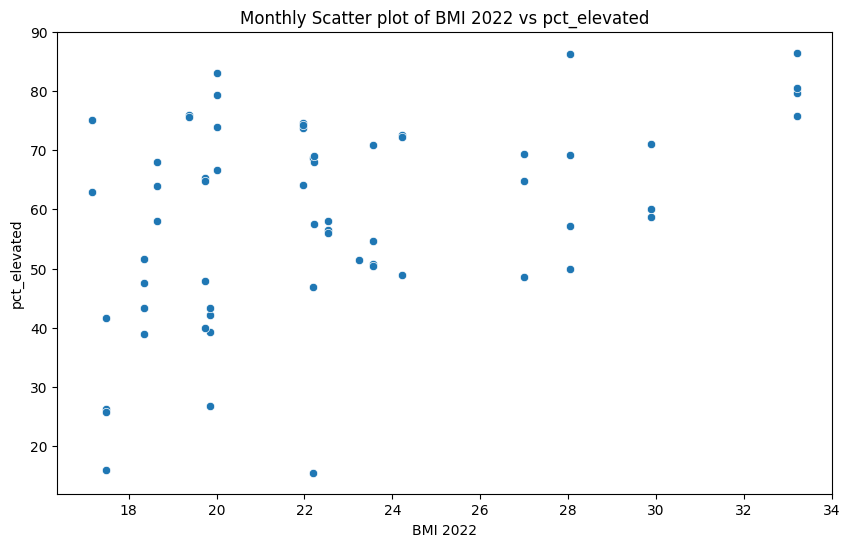

In [30]:
# plot bmi_2022 vs a selected score, e.g., glucose_mean for MONTHLY averages
selected_score = 'pct_elevated'
plt.figure(figsize=(10, 6))
merged_bmi_month_df = pd.merge(grouped_month_df[['id', selected_score]], bmi_df, on='id', how='inner')
sns.scatterplot(data=merged_bmi_month_df, x='bmi_2022', y=selected_score)
plt.title(f'Monthly Scatter plot of BMI 2022 vs {selected_score}')
plt.xlabel('BMI 2022')
plt.ylabel(selected_score)
plt.show()

In [31]:
# Now let's use some of the google stuff to predic tthis!
# I'm going to input person-wide features to predict these for these 21 people

# age, BMI, HRV_mean to calculate this
# IF I can do this, then I could try predicting this by phase

# I have BMI
# I can get age from the subject-info.csv
subject_info_df = pd.read_csv('subject-info.csv')
# calculate age in 2022 from birth_year
subject_info_df['age_2022'] = 2022 - subject_info_df['birth_year']
# merge with bmi df
age_bmi_df = pd.merge(subject_info_df[['id', 'age_2022']], bmi_df, on='id', how='inner')
age_bmi_df.head(3)

# Now get HRV for each week per person



,id,age_2022,bmi_2022
0,3,22,18.645344
1,4,22,26.989619
2,7,21,19.377163


In [39]:
# === HRV preprocessing & aggregation ===
# Dependencies: pandas, numpy
import pandas as pd
import numpy as np
from typing import Optional, Union, Tuple

def _safe_ratio(num, den):
    """Compute a stable ratio with zero/NaN handling."""
    num = np.asarray(num, dtype=float)
    den = np.asarray(den, dtype=float)
    out = np.divide(num, den, out=np.full_like(num, np.nan, dtype=float), where=den!=0)
    return out

def _winsorize(series: pd.Series, lower=0.01, upper=0.99) -> pd.Series:
    """Light anti-outlier cap using quantiles (keeps scale intact)."""
    if series.isna().all():
        return series
    lo, hi = series.quantile([lower, upper])
    return series.clip(lower=lo, upper=hi)

def build_datetime(
    df: pd.DataFrame,
    *,
    time_col: str = "timestamp",
    day_in_study_col: str = "day_in_study",
    study_interval_col: str = "study_interval",
    # Optionally pass a real anchor date per subject (dict like {id: "2022-05-01"})
    per_id_anchor: Optional[dict] = None,
    id_col: str = "id",
) -> pd.Series:
    """
    Construct a timezone-naive datetime from study fields.
    Assumptions:
      - `day_in_study` is 1-indexed (day 1 = first day).
      - If no real anchor is provided, we use Jan 1 of `study_interval` as day 1.
      - `timestamp` is a HH:MM:SS string.

    If you actually have calendar dates, replace this with:
        pd.to_datetime(df["date"] + " " + df["timestamp"])
    """
    # If per-id anchors are provided, use them; else default to Jan 1 of study_interval.
    if per_id_anchor is not None:
        # Vectorized map of anchor per row
        anchor = df[id_col].map(per_id_anchor)
        # Fallback for rows whose id not in dict: Jan 1 of study_interval
        fallback = pd.to_datetime(df[study_interval_col].astype(str) + "-01-01")
        anchor = pd.to_datetime(anchor).fillna(fallback)
    else:
        anchor = pd.to_datetime(df[study_interval_col].astype(str) + "-01-01")

    day_offset = pd.to_timedelta(df[day_in_study_col].astype(int) - 1, unit="D")
    time_part = pd.to_timedelta(pd.to_timedelta(df[time_col].astype(str)))
    dt = anchor + day_offset + time_part
    return dt

def preprocess_hrv_rows(
    df: pd.DataFrame,
    *,
    id_col: str = "id",
    time_col: str = "timestamp",
    day_in_study_col: str = "day_in_study",
    study_interval_col: str = "study_interval",
    rmssd_col: str = "rmssd",
    lf_col: str = "low_frequency",
    hf_col: str = "high_frequency",
    coverage_col: str = "coverage",
    is_weekend_col: Optional[str] = "is_weekend",
    per_id_anchor: Optional[dict] = None,
    min_coverage: float = 0.80,
    max_coverage: float = 1.05,  # allow slight >1 inflation as in your sample
    winsorize_cols: Optional[list] = None,
    winsor_lower: float = 0.01,
    winsor_upper: float = 0.99,
) -> pd.DataFrame:
    """
    Row-level cleaning + feature engineering.
    Returns a new DataFrame with:
      - dt (datetime index-ready)
      - engineered features: lf_hf, log1p transforms, quality flag, etc.
    """
    df = df.copy()

    # Build datetime
    df["dt"] = build_datetime(
        df,
        time_col=time_col,
        day_in_study_col=day_in_study_col,
        study_interval_col=study_interval_col,
        per_id_anchor=per_id_anchor,
        id_col=id_col,
    )

    # Basic quality flags
    df["valid_coverage"] = df[coverage_col].between(min_coverage, max_coverage, inclusive="both")
    # NaN-safe positives
    df["valid_signal"] = (
        df[rmssd_col].gt(0).fillna(False)
        & df[lf_col].ge(0).fillna(False)
        & df[hf_col].ge(0).fillna(False)
    )
    df["is_valid"] = df["valid_coverage"] & df["valid_signal"]

    # Feature engineering
    df["lf_hf"] = _safe_ratio(df[lf_col], df[hf_col])
    # log1p is robust to zeros; apply to skewed features
    df["log_rmssd"] = np.log1p(df[rmssd_col].clip(lower=0))
    df["log_lf"] = np.log1p(df[lf_col].clip(lower=0))
    df["log_hf"] = np.log1p(df[hf_col].clip(lower=0))
    df["log_lf_hf"] = np.log1p(df["lf_hf"].clip(lower=0))

    # Optional light winsorization to reduce the impact of outliers
    if winsorize_cols is None:
        winsorize_cols = [rmssd_col, lf_col, hf_col, "lf_hf", "log_rmssd", "log_lf", "log_hf", "log_lf_hf"]
    for c in winsorize_cols:
        if c in df.columns:
            df[c + "_w"] = _winsorize(df[c], lower=winsor_lower, upper=winsor_upper)

    # Circadian encodings (helpful if you later aggregate by non-circadian windows)
    # Convert local time (0..24h) to cyclical features
    day_seconds = (df["dt"].dt.hour * 3600 + df["dt"].dt.minute * 60 + df["dt"].dt.second)
    circadian_angle = 2 * np.pi * day_seconds / (24 * 3600)
    df["time_sin"] = np.sin(circadian_angle)
    df["time_cos"] = np.cos(circadian_angle)

    # Weekend boolean (if not already present); True/False values
    if is_weekend_col is None or is_weekend_col not in df.columns:
        df["is_weekend_flag"] = df["dt"].dt.dayofweek >= 5
    else:
        df["is_weekend_flag"] = df[is_weekend_col].astype(bool)

    # Tidy columns order (optional)
    # Keep original + engineered + QC
    return df
import pandas as pd
import numpy as np
from typing import Optional, Union, Tuple, List

def aggregate_hrv_by_dayrange(
    df_clean: pd.DataFrame,
    *,
    id_col: str = "id",
    day_col: str = "day_in_study",
    study_interval_col: str = "study_interval",
    window_days: int = 2,               # inclusive range size, e.g., 2 → (7,8), (9,10), ...
    min_rows_per_window: int = 6,       # require at least N raw rows per window
    min_valid_fraction: float = 0.7,    # require >=70% rows in window to be valid
    aggregate_winsorized: bool = True,
    # Optional: provide custom explicit ranges per subject; if given, overrides auto windows.
    # Format: {subject_id: [(start_day, end_day), (start_day, end_day), ...]}
    custom_ranges: Optional[dict] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Aggregate HRV rows into inclusive day_in_study ranges per participant.
    Returns (window_features, window_quality).
    Each window is identified by (id, window_start_day, window_end_day).
    """

    if window_days < 1:
        raise ValueError("window_days must be >= 1")

    df = df_clean.copy()

    # Choose which numeric columns to aggregate (same as datetime-based version)
    base_cols = [
        "rmssd", "low_frequency", "high_frequency", "lf_hf",
        "log_rmssd", "log_lf", "log_hf", "log_lf_hf",
        "time_sin", "time_cos",
    ]
    if aggregate_winsorized:
        base_cols += [c for c in df.columns if c.endswith("_w")]
    agg_cols = [c for c in base_cols if c in df.columns]

    def window_agg(group: pd.DataFrame) -> dict:
        """Aggregate within a window; returns dict of features + QC."""
        n_total = len(group)
        n_valid = int(group.get("is_valid", pd.Series(index=group.index, dtype=bool)).sum())
        valid_frac = n_valid / n_total if n_total > 0 else np.nan

        g = group[group.get("is_valid", True)].copy()

        out = {}
        if g.empty:
            for c in agg_cols:
                out[f"{c}_mean"] = np.nan
                out[f"{c}_median"] = np.nan
                out[f"{c}_std"] = np.nan
                out[f"{c}_p25"] = np.nan
                out[f"{c}_p75"] = np.nan
            out["prop_sympathetic_dom"] = np.nan
            out["prop_parasymp_dom"] = np.nan
            out["cv_rmssd"] = np.nan
        else:
            for c in agg_cols:
                s = g[c]
                out[f"{c}_mean"]   = s.mean()
                out[f"{c}_median"] = s.median()
                out[f"{c}_std"]    = s.std(ddof=1)
                out[f"{c}_p25"]    = s.quantile(0.25)
                out[f"{c}_p75"]    = s.quantile(0.75)

            lf_hf = g.get("lf_hf", pd.Series(index=g.index, dtype=float))
            out["prop_sympathetic_dom"] = (lf_hf > 2).mean() if not lf_hf.empty else np.nan
            out["prop_parasymp_dom"] = (lf_hf < 1).mean() if not lf_hf.empty else np.nan

            rmssd = g.get("rmssd", pd.Series(index=g.index, dtype=float))
            out["cv_rmssd"] = (
                rmssd.std(ddof=1) / rmssd.mean()
                if rmssd.notna().sum() > 1 and rmssd.mean() > 0
                else np.nan
            )

        out["n_rows"] = n_total
        out["n_valid"] = n_valid
        out["valid_fraction"] = valid_frac

        # For reference: most common study_interval in the window (useful if you track across years)
        if study_interval_col in group.columns:
            mode_vals = group[study_interval_col].mode(dropna=True)
            out["study_interval_mode"] = mode_vals.iloc[0] if len(mode_vals) else np.nan
        else:
            out["study_interval_mode"] = np.nan

        return out

    def make_non_overlapping_ranges(min_day: int, max_day: int, k: int) -> List[Tuple[int, int]]:
        """Build inclusive [start, end] day ranges of length k: (1..k), (k+1..2k), ..."""
        ranges = []
        d = int(min_day)
        while d <= int(max_day):
            end = min(d + k - 1, int(max_day))
            ranges.append((d, end))
            d = end + 1
        return ranges

    # Build windows and aggregate per subject
    rows = []
    for subject_id, sdf in df.groupby(id_col, group_keys=False):
        sdf = sdf.copy()
        if day_col not in sdf.columns:
            raise ValueError(f"Expected '{day_col}' in DataFrame.")
        # Ensure integer day values
        days = pd.to_numeric(sdf[day_col], errors="coerce").astype("Int64")

        # Decide ranges
        if custom_ranges and subject_id in custom_ranges:
            ranges = custom_ranges[subject_id]
        else:
            min_day = int(days.min())
            max_day = int(days.max())
            ranges = make_non_overlapping_ranges(min_day, max_day, window_days)

        for (start_day, end_day) in ranges:
            mask = (days >= start_day) & (days <= end_day)
            g = sdf[mask]

            feats = window_agg(g)
            feats[id_col] = subject_id
            feats["window_start_day"] = int(start_day)
            feats["window_end_day"] = int(end_day)

            rows.append(feats)

    if not rows:
        # Return empty frames with expected schema
        features = pd.DataFrame(columns=[id_col, "window_start_day", "window_end_day", "window_pass_qc"])
        quality = pd.DataFrame(columns=[id_col, "window_start_day", "window_end_day", "n_rows", "n_valid", "valid_fraction", "window_pass_qc"])
        return features, quality

    agg_df = pd.DataFrame(rows)

    # QC mask
    qc_mask = (agg_df["n_rows"] >= min_rows_per_window) & (agg_df["valid_fraction"] >= min_valid_fraction)
    agg_df["window_pass_qc"] = qc_mask

    # Split outputs
    quality_cols = [id_col, "window_start_day", "window_end_day", "n_rows", "n_valid", "valid_fraction", "window_pass_qc"]
    # Include study_interval_mode in quality for reference if present
    if "study_interval_mode" in agg_df.columns:
        quality_cols.append("study_interval_mode")

    quality = agg_df[quality_cols].copy()
    features = agg_df.copy()  # modeling features + QC (drop if you want pure features)
    return features, quality



In [47]:
# Read & preprocess (unchanged)
df = pd.read_csv("heart_rate_variability_details.csv")
df_clean = preprocess_hrv_rows(df)  # your existing function from earlier

# Aggregate into inclusive 2-day windows: (1,2), (3,4), ..., or (7,8), (9,10), ...
features_2d, quality_2d = aggregate_hrv_by_dayrange(df_clean, window_days=2)

# Aggregate into 1-day windows (start==end)
features_1d, quality_1d = aggregate_hrv_by_dayrange(df_clean, window_days=1)

# Keep only QC-passing windows
X_2d = features_2d[features_2d["window_pass_qc"]].reset_index(drop=True)


In [ ]:
features_1d.head(3)

,rmssd_mean,rmssd_median,rmssd_std,rmssd_p25,rmssd_p75,low_frequency_mean,low_frequency_median,low_frequency_std,low_frequency_p25,low_frequency_p75,...,prop_parasymp_dom,cv_rmssd,n_rows,n_valid,valid_fraction,study_interval_mode,id,window_start_day,window_end_day,window_pass_qc
0,41.367000,41.2935,1.005746,40.86725,41.79325,522.875750,533.728,378.988077,223.66550,832.93825,...,0.500000,0.024313,5,4,0.8,2022.0,2,7,7,False
1,46.127240,44.6445,11.736847,36.75850,55.95700,789.802279,728.283,539.347006,459.39575,979.93375,...,0.307692,0.254445,104,104,1.0,2022.0,2,8,8,True
2,45.416714,46.3810,11.206875,39.40000,52.80200,787.655714,614.358,583.575182,440.55200,989.43400,...,0.352381,0.246757,105,105,1.0,2022.0,2,9,9,True


In [43]:
# ===============================================================================
# MACHINE LEARNING PIPELINE: Predict Glucose Scores from HRV + Demographics
# ===============================================================================

from sklearn.model_selection import GroupShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STEP 1: Merge features_1d with BMI and age data")
print("="*80)

# Start with features_1d (only QC-passing windows)
features_base = features_1d[features_1d["window_pass_qc"]].copy()
print(f"Starting with {len(features_base)} HRV feature rows (QC-passed)")

# Merge with age and BMI
features_with_demo = features_base.merge(age_bmi_df, on='id', how='inner')
print(f"After merging with age/BMI: {len(features_with_demo)} rows")
print(f"Unique subjects: {features_with_demo['id'].nunique()}")

# Use window_start_day as the representative day for this window
features_with_demo['day_in_study'] = features_with_demo['window_start_day']

print("\n" + "="*80)
print("STEP 2: Create monthly aggregation (30-day bins)")
print("="*80)

# Create month bins: 1-30, 31-60, 61-90, etc.
features_with_demo['month_bin'] = ((features_with_demo['day_in_study'] - 1) // 30) + 1
print(f"Month bins created: {sorted(features_with_demo['month_bin'].unique())}")

# Identify numeric columns to aggregate (exclude IDs, QC flags, etc.)
exclude_cols = ['id', 'window_start_day', 'window_end_day', 'day_in_study', 'month_bin', 
                'window_pass_qc', 'study_interval_mode', 'n_rows', 'n_valid', 'valid_fraction']
numeric_cols = [c for c in features_with_demo.select_dtypes(include=[np.number]).columns 
                if c not in exclude_cols]
print(f"Aggregating {len(numeric_cols)} numeric features per subject per month")

# Group by subject and month, average all features
monthly_features = features_with_demo.groupby(['id', 'month_bin'])[numeric_cols].mean().reset_index()
print(f"Monthly aggregated features shape: {monthly_features.shape}")

print("\n" + "="*80)
print("STEP 3: Merge with glucose scores (targets)")
print("="*80)

# Load daily cremaster scores and create monthly bins
daily_scores = pd.read_csv('daily_cremaster_scores.00.csv')
daily_scores['month_bin'] = ((daily_scores['day_in_study'] - 1) // 30) + 1

# Aggregate glucose scores by subject and month
score_cols = [c for c in daily_scores.select_dtypes(include=[np.number]).columns 
              if c not in ['id', 'day_in_study', 'month_bin']]
monthly_scores = daily_scores.groupby(['id', 'month_bin'])[score_cols].mean().reset_index()
print(f"Monthly glucose scores shape: {monthly_scores.shape}")
print(f"Target scores: {score_cols}")

# Merge features with targets
ml_data = monthly_features.merge(monthly_scores, on=['id', 'month_bin'], how='inner')
print(f"\nFinal merged dataset shape: {ml_data.shape}")
print(f"Subjects: {ml_data['id'].nunique()}, Months: {len(ml_data)}")

# Remove any rows with missing values
ml_data_clean = ml_data.dropna()
print(f"After removing NaN rows: {ml_data_clean.shape}")

print("\n" + "="*80)
print("STEP 4: Prepare features and targets")
print("="*80)

# Separate features (X) and targets (y)
feature_cols = [c for c in ml_data_clean.columns if c not in ['id', 'month_bin'] + score_cols]
X = ml_data_clean[feature_cols].values
y = ml_data_clean[score_cols].values
groups = ml_data_clean['id'].values  # For subject-based splitting

print(f"Feature matrix X: {X.shape}")
print(f"Target matrix y: {y.shape} ({len(score_cols)} glucose scores)")
print(f"Unique subjects: {len(np.unique(groups))}")

print("\n" + "="*80)
print("STEP 5: Subject-based train/test split (80/20)")
print("="*80)

# Use GroupShuffleSplit to ensure subjects don't overlap between train/test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

train_subjects = np.unique(groups[train_idx])
test_subjects = np.unique(groups[test_idx])
print(f"Train set: {len(X_train)} samples from {len(train_subjects)} subjects")
print(f"Test set: {len(X_test)} samples from {len(test_subjects)} subjects")
print(f"Subject overlap check: {len(set(train_subjects) & set(test_subjects))} (should be 0)")

# Scale features (fit on train only to prevent leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*80)
print("STEP 6: Train models for each glucose score")
print("="*80)

# Models to compare
models = {
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, 
                            random_state=42, n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, 
                                           random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, 
                                                    learning_rate=0.1, random_state=42)
}

results = {}

for score_idx, score_name in enumerate(score_cols):
    print(f"\n{'='*60}")
    print(f"Training models for: {score_name}")
    print(f"{'='*60}")
    
    y_train_score = y_train[:, score_idx]
    y_test_score = y_test[:, score_idx]
    
    score_results = {}
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train_score)
        
        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Metrics
        train_r2 = r2_score(y_train_score, y_pred_train)
        test_r2 = r2_score(y_test_score, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test_score, y_pred_test))
        test_mae = mean_absolute_error(y_test_score, y_pred_test)
        
        score_results[model_name] = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'y_pred_test': y_pred_test,
            'y_test': y_test_score
        }
        
        print(f"  {model_name:20s} | Train R²: {train_r2:6.3f} | Test R²: {test_r2:6.3f} | "
              f"RMSE: {test_rmse:6.3f} | MAE: {test_mae:6.3f}")
    
    results[score_name] = score_results

print("\n" + "="*80)
print("STEP 7: Summary of best models per score")
print("="*80)

summary_data = []
for score_name, score_results in results.items():
    best_model_name = max(score_results.keys(), key=lambda k: score_results[k]['test_r2'])
    best_result = score_results[best_model_name]
    
    summary_data.append({
        'Score': score_name,
        'Best Model': best_model_name,
        'Test R²': best_result['test_r2'],
        'Test RMSE': best_result['test_rmse'],
        'Test MAE': best_result['test_mae']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test R²', ascending=False)
print("\n", summary_df.to_string(index=False))

# Store results for later visualization
prediction_results = results

STEP 1: Merge features_1d with BMI and age data
Starting with 4811 HRV feature rows (QC-passed)
After merging with age/BMI: 2373 rows
Unique subjects: 18

STEP 2: Create monthly aggregation (30-day bins)
Month bins created: [np.int64(1), np.int64(2), np.int64(3), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34)]
Aggregating 95 numeric features per subject per month
Monthly aggregated features shape: (92, 97)

STEP 3: Merge with glucose scores (targets)
Monthly glucose scores shape: (120, 12)
Target scores: ['daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose', 'n_points', 'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_60', 'k_decay', 'cremaster_score_daily_global']

Final merged dataset shape: (49, 107)
Subjects: 18, Months: 49
After removing NaN rows: (49, 107)

STEP 4: Prepare features and targets
Feature matrix X: (49, 95)
Target matrix y: (49, 10) (10 glucose scores)
Unique subjects: 18

STEP 5: Subject-based train/test split (80/20)
T

STEP 8: Visualize predictions and feature importance


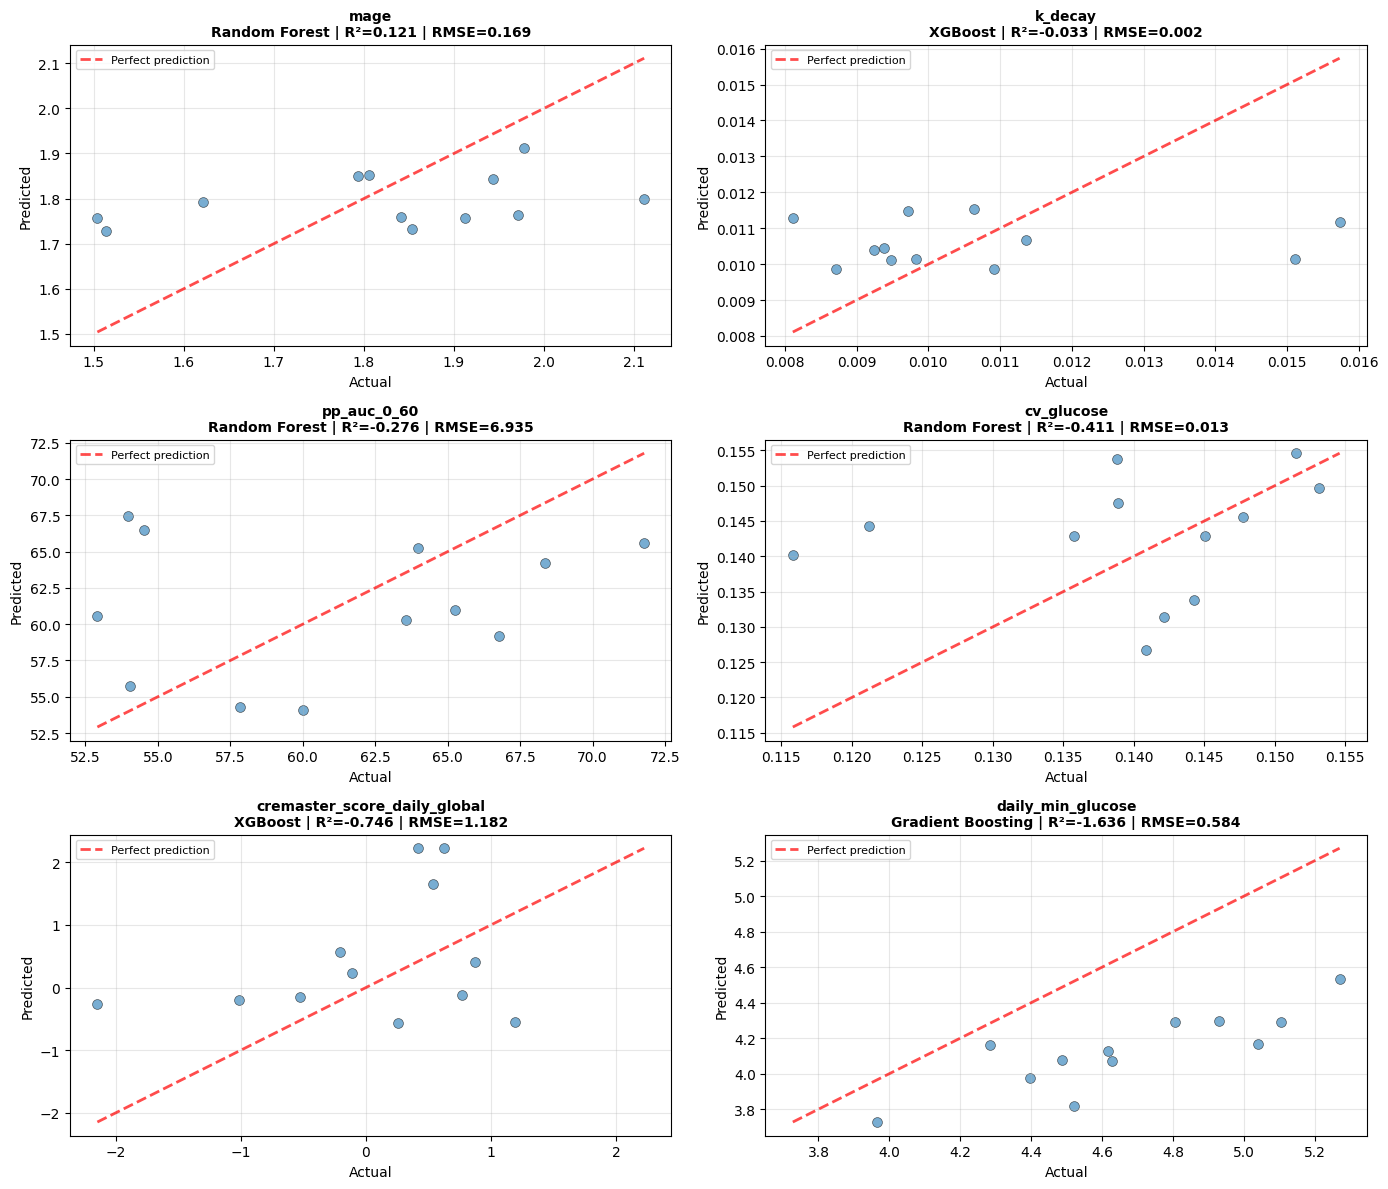


Feature Importance Analysis (XGBoost models)


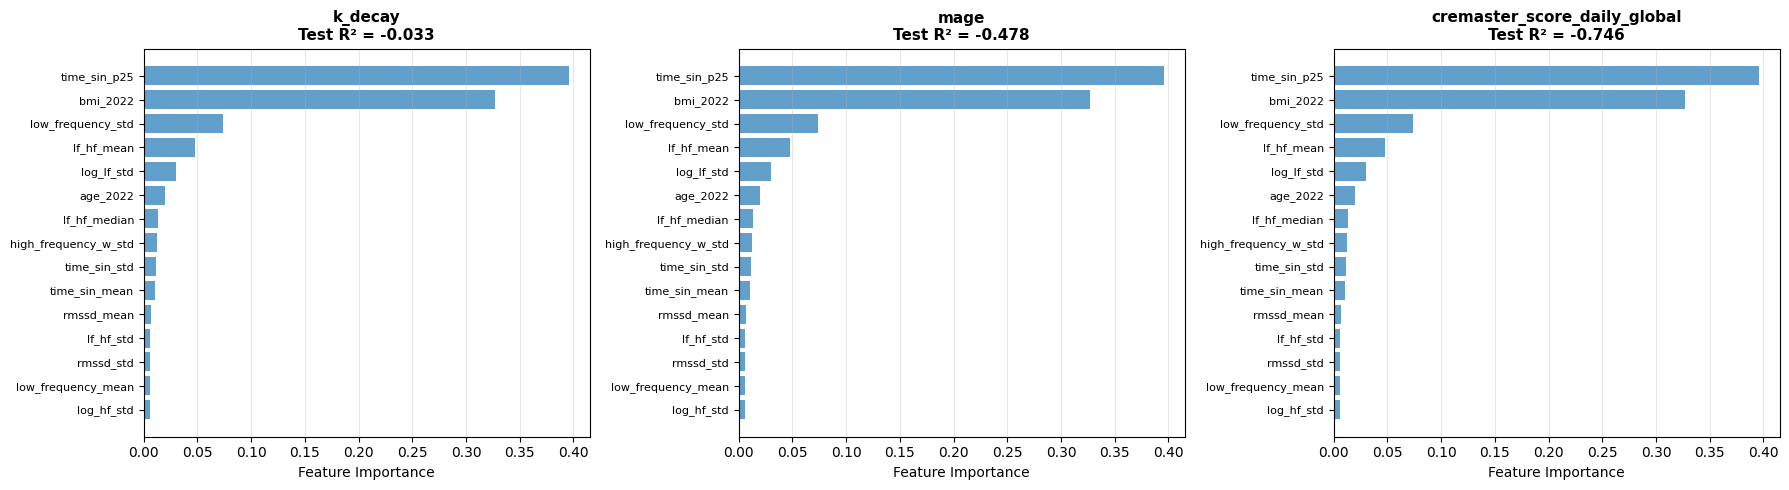


✅ Machine learning pipeline complete!
Trained 3 models on 10 glucose scores
Used subject-based splitting to prevent data leakage
Results stored in 'prediction_results' and 'summary_df' variables


In [44]:
# ===============================================================================
# VISUALIZATION: Actual vs Predicted & Feature Importance
# ===============================================================================

print("="*80)
print("STEP 8: Visualize predictions and feature importance")
print("="*80)

# Select top 6 best-performing scores for visualization
top_scores = summary_df.head(6)['Score'].values

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, score_name in enumerate(top_scores):
    ax = axes[idx]
    
    # Get best model for this score
    score_results = prediction_results[score_name]
    best_model_name = max(score_results.keys(), key=lambda k: score_results[k]['test_r2'])
    best_result = score_results[best_model_name]
    
    y_test_score = best_result['y_test']
    y_pred_test = best_result['y_pred_test']
    test_r2 = best_result['test_r2']
    test_rmse = best_result['test_rmse']
    
    # Scatter plot: actual vs predicted
    ax.scatter(y_test_score, y_pred_test, alpha=0.6, s=50, edgecolors='k', linewidths=0.5)
    
    # Perfect prediction line
    min_val = min(y_test_score.min(), y_pred_test.min())
    max_val = max(y_test_score.max(), y_pred_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.7, label='Perfect prediction')
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{score_name}\n{best_model_name} | R²={test_r2:.3f} | RMSE={test_rmse:.3f}', 
                 fontsize=10, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for XGBoost models
print("\n" + "="*80)
print("Feature Importance Analysis (XGBoost models)")
print("="*80)

# Get top 3 scores with best XGBoost performance
xgb_scores = []
for score_name in score_cols:
    if 'XGBoost' in prediction_results[score_name]:
        test_r2 = prediction_results[score_name]['XGBoost']['test_r2']
        xgb_scores.append((score_name, test_r2))
xgb_scores.sort(key=lambda x: x[1], reverse=True)
top_3_xgb = [s[0] for s in xgb_scores[:3]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, score_name in enumerate(top_3_xgb):
    ax = axes[idx]
    
    model = prediction_results[score_name]['XGBoost']['model']
    test_r2 = prediction_results[score_name]['XGBoost']['test_r2']
    
    # Get feature importances
    importances = model.feature_importances_
    feature_names = feature_cols
    
    # Sort by importance
    indices = np.argsort(importances)[-15:]  # Top 15 features
    
    ax.barh(range(len(indices)), importances[indices], alpha=0.7)
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices], fontsize=8)
    ax.set_xlabel('Feature Importance', fontsize=10)
    ax.set_title(f'{score_name}\nTest R² = {test_r2:.3f}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Machine learning pipeline complete!")
print(f"Trained {len(models)} models on {len(score_cols)} glucose scores")
print(f"Used subject-based splitting to prevent data leakage")
print(f"Results stored in 'prediction_results' and 'summary_df' variables")

### Considering our options now, with only 2 days to work left…

**Current Status:**
All 15 cremaster scores are not easily predicted.

**Options:**

1. **Predict a non-glucose/non-daily feature**
    - Hormones

2. **Change scope/binning**
    - Predict following days using previous week of features (like next day of cremaster's score using previous week of HRV)

3. **Submit findings that show differences between phases of the cycle**
    - This is not really using the fitbit aspect
    - But this can honestly be included as a null result
    - We can show that these are consistent within phases
    - We can show that these are consistent or not consistent within individuals
    - We could still feed this into an AI and still proof of concept the period-pal health agent similar to the google paper

4. **Could pivot to try to do pure time-series prediction w/ glucose**
    - In other words, use previous week to predict glucose dynamics and then can verify using some cremaster's scores
    - As long as hormones are an input, we could still draw connection between period and glucose

5. **[Use Talmo's automated research framework](https://simonwillison.net/2025/Nov/6/async-code-research/)**
    - My old PI sent me a framework for letting coding agents rip and do this type of work
    - We could let it go ham on what we have and try to salvage some findings
    - 


6. **Follow Sid's google paper more directly**
    - [The paper](https://research.google/blog/insulin-resistance-prediction-from-wearables-and-routine-blood-biomarkers/)
